<h2>Training Feature Basis Functions</h2>

Here we seek to train a custom basis function feature for every control track. This way we can use just one feature for each control track while still capturing the unique biases present in each track. We do this using fused ridge regression to smooth out these basis functions.

<h3>Code</h3>

In [1]:
@everywhere using PureSeq
@everywhere using DataStructures
using Gadfly

In [2]:
@everywhere function learn_feature(targetFile, controlFile, nbins; useReverseReads=false, maxCount=3200000000, keepDuplicates=false)
    targetReader = BamReader(targetFile, useReverseReads, ReferenceContigs_hg38)
    controlReader = BamReader(controlFile, useReverseReads, ReferenceContigs_hg38)
    P = 2*nbins + 1
    XtXcounts = zeros(Int64, P)
    Xty = zeros(Int64, P)
    targetValue = 0
    controlQueue = Deque{(Int64,Int64)}()
    tmp = Array(Int64, P)
    countTenth = int(maxCount/10)
    
    for i in 1:maxCount
        
        # remove old control positions that fell outside the sliding window
        while length(controlQueue) > 0 && front(controlQueue)[1] < i-nbins
            shift!(controlQueue)
        end
        
        # add new control positions in the sliding window
        if position(controlReader) != -1 && position(controlReader) <= i+nbins
            value = 0
            
            # get all the reads at this position
            pos = position(controlReader)
            while position(controlReader) == pos
                value += 1
                advance!(controlReader)
            end
            if !keepDuplicates
                value = 1
            end
            push!(controlQueue, (pos, value)) 
            
            # update XtXcount
            for (pos1,value1) in controlQueue
                XtXcounts[pos-pos1+1] += value*value1
            end
        end
        
        # get the current target count
        targetValue = 0
        while position(targetReader) == i
            targetValue += 1
            advance!(targetReader)
        end
        if !keepDuplicates && targetValue != 0
            targetValue = 1
        end
        
        # update Xty
        if targetValue != 0
            for (pos1,value1) in controlQueue
                Xty[pos1 - i + nbins + 1] += targetValue*value1
            end
        end
        
        if i % countTenth == 0
            println(i)
        end
    end
    
    close(targetReader)
    close(controlReader)
    
    XtXcounts, Xty
end

@everywhere function build_XtX(XtXcounts)
    P = length(XtXcounts)
    XtX = zeros(Float64, P, P)
    for i in 1:P
        for j in i:P
            XtX[j,i] = XtX[i,j] = XtXcounts[j-i+1]
        end
    end
    XtX
end

@everywhere function fused_ridge(XtX, Xty, lambda)
    P = length(Xty)
    D = eye(P)
    for i in 1:P-1
        D[i,i+1] = -1
    end
    D[P,P] /= lambda
    invD = inv(D)
    invD*inv(invD'XtX*invD .+ lambda*eye(P))*invD'Xty
end

@everywhere function bin_values(arr, step)
    out = Float64[]
    for i = 1:step:length(arr)
        push!(out, mean(arr[i:min(i+step-1,length(arr))]))
    end
    out
end

<h3>Load Metadata</h3>

In [79]:
# find out the target label and other metadata of all the experiments
metadataDir = "/homes/gws/slund1/projects/genomic-structure-learning/data/metadata"
metadata = Dict()
controlIds = ASCIIString[]
for file in readdir(metadataDir)
    obj = open(f->JSON.parse(readall(f)), "$metadataDir/$file")
    metadata[obj["accession"]] = obj
    if ismatch(r"[Cc]ontrol", obj["target"]["label"])
        for file in obj["files"]
            asc = file["accession"]
            if file["file_format"] == "fastq"
                push!(controlIds, asc)
            end
        end
    end
end

<h3>Build all feature files for ENCFF000NYK</h3>

In [88]:
@everywhere targetId = "ENCFF000NYK"
@everywhere function save_feature(root, targetId, controlId, nbins; useReverseReads=false)
    XtXcounts, Xty = learn_feature(
        "$root/$targetId.bam",
        "$root/$controlId.bam",
        nbins,
        useReverseReads=useReverseReads
    )
    
    # solve for the betas and save them
    betas = inv(build_XtX(XtXcounts))*Xty
    writedlm("$root/$(targetId)_vs_$(controlId)_w50.txt", betas)
end

In [82]:
addprocs(14)

14-element Array{Any,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15

In [86]:
@everywhere root = "/scratch2/slund1/ENCSR000BQS_notebook"
@parallel for i in 1:length(controlIds)
    println(controlIds[i])
    if !isfile("$root/$(targetId)_vs_$(controlId)_w50.txt")
        save_feature(root, targetId, controlIds[i], 50)
    end
end

	From worker 4:	ENCFF000AOG
	From worker 3:	ENCFF000QQG
	From worker 6:	ENCFF000QVY
	From worker 7:	ENCFF000ZVZ
	From worker 8:	ENCFF000ZIB
	From worker 14:	ENCFF002ECW
	From worker 12:	ENCFF000YCS
	From worker 9:	ENCFF001FFI
	From worker 5:	ENCFF000NPN
	From worker 10:	ENCFF001HWJ
	From worker 11:	ENCFF000WKH
	From worker 13:	ENCFF000XJD
	From worker 2:	ENCFF002EHD
	From worker 15:	ENCFF002ECP
	From worker 11:	320000000
	From worker 6:	320000000
	From worker 12:	320000000
	From worker 10:	320000000
	From worker 9:	320000000
	From worker 8:	320000000
	From worker 13:	320000000
	From worker 15:	320000000
	From worker 11:	640000000
	From worker 4:	320000000
	From worker 6:	640000000


In [67]:
@time save_feature("$root/$targetId.bam", "$root/$controlId.bam", 50)

320000000
640000000
960000000
1280000000
1600000000
1920000000
2240000000
2560000000
2880000000
3200000000
elapsed time: 148.526536311 seconds (6045427776 bytes allocated, 6.29% gc time)


101-element Array{Float64,1}:
 0.00246061
 0.00247991
 0.00249966
 0.00247274
 0.00246698
 0.00246275
 0.00246976
 0.00247436
 0.00245593
 0.00249473
 0.00247285
 0.00248121
 0.00247894
 ⋮         
 0.00244505
 0.00241098
 0.00246192
 0.00241239
 0.00242124
 0.00241941
 0.00243701
 0.00241004
 0.00239086
 0.00242322
 0.00245826
 0.00239934

<h3>Compare different window sizes</h3>

How wide we make the basis functions should be driven by the length of dependency along the genome. Here we test multiple different lengths to see how the marginal correlation between a target position and a control position varies as the distance between target and control position increases.

<h4>60,001 base window</h4>

In [11]:
root = "/scratch2/slund1/pure-seq/binned_data"
targetId = "ENCFF000NYK"
controlIds = ["ENCFF000ODO", "ENCFF000ODV"]
XtXcounts_30k, Xty_30k = learn_feature(
    "$root/$targetId.bam",
    "$root/$(controlIds[1]).bam",
    30000,
    useReverseReads=false
)
open(f->write(f, XtXcounts_30k), "/tmp/XtXcounts_30k.jbin", "w")
open(f->write(f, Xty_30k), "/tmp/Xty_30k.jbin", "w")
# XtXcounts_30k = zeros(Int64, 600001)
# XtXy_30k = zeros(Int64, 600001)
# open(f->read!(f, XtXcounts_30k), "/tmp/XtXcounts_30k.jbin")
# open(f->read!(f, XtXy_30k), "/tmp/XtXy_30k.jbin")
XtXcounts_30k_binned = bin_values(XtXcounts_30k, 100)
Xty_30k_binned = bin_values(Xty_30k, 100);

320000000
640000000
960000000
1280000000
1600000000
1920000000
2240000000
2560000000
2880000000
3200000000


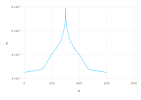

In [12]:
plot(x=1:length(Xty_30k_binned), y=Xty_30k_binned, Geom.line)

<h4>4,001 base window</h4>

In [27]:
#plot(x=1:4001, y=Xty_30k[30001-2000:30001+2000], Geom.line)
println(Xty_30k[30001-2000:30001+2000])

[49081,49241,49217,49060,49219,49198,48836,48851,49114,48822,49001,49169,49225,49044,49207,49213,49113,48729,49274,49084,49012,48981,48915,49167,48927,48793,49197,49479,49077,48996,49295,49104,49140,48918,49214,48926,48989,48949,48999,48918,49151,48835,49108,49213,49252,48816,49204,49115,49423,49236,49252,48993,49183,49111,49199,49022,49030,49423,48822,49275,49311,49337,49155,49298,49385,48921,49007,49351,49283,49376,49321,49002,49221,49134,49198,49160,49228,48675,49183,49117,49164,49081,49588,48869,49060,49300,49034,49536,48971,49521,49267,49438,49657,49354,49226,49578,48957,49328,49197,49176,49377,49399,49319,49371,49487,49356,49071,49152,49007,49253,49467,49380,49296,49456,49335,48741,48925,48990,49206,49241,48963,48975,49172,49109,49462,49449,49454,49374,49161,49527,48991,49183,49287,49188,49367,48947,49259,49258,49290,49404,49383,49665,49233,49733,49224,49412,49147,49015,49123,48946,49281,49448,49442,49600,49280,49225,49320,49473,49391,49326,48999,49457,49555,49552,49402,49679,492

<h4>401 base window</h4>

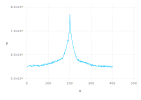

In [14]:
plot(x=1:401, y=Xty_30k[30001-200:30001+200], Geom.line)

<h3>Compare marginal vs. conditional association</h3>

While the marginal correlations plotted above show how the similarity between a target and control position decays with increasing distance, it does not show how important each position is for linear prediction. To do this we run a linear regression algorithm to estimate a $\beta_i$ for each distance $i$.

In the figures below it is apparent that while the similarity between a target position value and a control position extends a long ways through the genome, the additional predictive value of distant position is actually very small. In other words the information contained in the similarity of distant genomic positions with the target position is redundant with respect to the infornation provided by closer positions. This is good since it means we can use a smaller window size when building a feature basis function. Since the basis function will be used for prediction it is the predictive value of a distance position in which we are interested.

<h4>60,001 base window</h4>

Because $60,001 \times 60,001$ is a very large matrix we first downsample by a factor of $100$ before performing regression. This lowers the resolution, but helps prevent over fitting and makes the computation tractable.

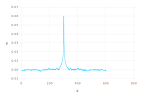

In [15]:
betas = inv(build_XtX(XtXcounts_30k_binned))*Xty_30k_binned
plot(x=1:length(betas), y=betas, Geom.line)

<h4>4,001 base window</h4>

In [26]:
betas = inv(build_XtX(XtXcounts_30k[1:4001]))*Xty_30k[30001-2000:30001+2000]
plot(x=1:length(betas), y=betas, Geom.line)

[8.547462102058488e-5,9.790764806552024e-5,9.565939031952987e-5,8.279559955454536e-5,9.522375510489572e-5,9.327053851234292e-5,6.40820280919854e-5,6.49980656267715e-5,8.575059185289139e-5,6.215717362761398e-5,7.616786771678469e-5,8.9287379900379e-5,9.347012535428266e-5,7.877321002897384e-5,9.156459890999863e-5,9.18019750584252e-5,8.354967876960561e-5,5.266363362875633e-5,9.59631850479705e-5,8.05563323147388e-5,7.45915978924522e-5,7.188342035644836e-5,6.642140686970384e-5,8.627522359791309e-5,6.690613909474211e-5,5.5908867637588234e-5,8.795263120487775e-5,0.00011026078666447083,7.795273793198042e-5,7.125685099655256e-5,9.491855168173948e-5,7.943463412814958e-5,8.216570036524956e-5,6.424204818750894e-5,8.768470276539255e-5,6.451752979027796e-5,6.930534174922559e-5,6.59304595061433e-5,6.973992866333374e-5,6.301823778019585e-5,8.147384035574967e-5,5.59971523101095e-5,7.763125386716594e-5,8.576947212826366e-5,8.871074176449333e-5,5.368395661956855e-5,8.44765075612231e-5,7.712675875130261e-5

<h4>401 base window</h4>

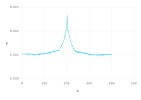

In [17]:
betas = inv(build_XtX(XtXcounts_30k[1:401]))*Xty_30k[30001-200:30001+200]
plot(x=1:length(betas), y=betas, Geom.line)

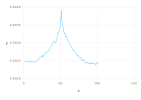

In [18]:
betas = inv(build_XtX(XtXcounts_30k[1:101]))*Xty_30k[30001-50:30001+50]
plot(x=1:length(betas), y=betas, Geom.line)

<h3>Fused ridge regression</h3>

Since we expect positions nearby each other to have similar predictive values it makes sense to regularize the functions to encourage values to be similar. This can be accomplished using Fused ridge regression as shown below for the $4,001$ base window.

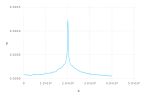

In [19]:
betas = fused_ridge(build_XtX(XtXcounts_30k[1:4001]), Xty_30k[30001-2000:30001+2000], 10e8)
plot(x=1:length(betas), y=betas, Geom.line)

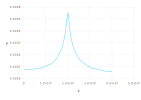

In [20]:
betas = fused_ridge(build_XtX(XtXcounts_30k[1:4001]), Xty_30k[30001-2000:30001+2000], 10e10)
plot(x=1:length(betas), y=betas, Geom.line)

<h3>Relax the penalty in the center</h3>

The penalty is supposed to express the prior that we expect over the parameters. In this case we expect a spike in the middle of the parameter set, so below we encode this knowledge by penalizing the difference between parameters in the middle much less than those at the edges.

In [21]:
function fused_ridge_center(XtX, Xty, lambda)
    P = length(Xty)
    D = eye(P)
    radius = float((P-1)/2)
    for i in 1:P-1
        D[i,i+1] = -1
        D[i,:] *= max(abs(i - radius - 1),1.0)/radius
    end
    D[P,P] /= lambda
    invD = inv(D)
    invD*inv(invD'XtX*invD .+ lambda*eye(P))*invD'Xty
end

fused_ridge_center (generic function with 1 method)

In [25]:
betas = fused_ridge_center(build_XtX(XtXcounts_30k[1:4001]), Xty_30k[30001-2000:30001+2000], 10e10)
plot(x=1:length(betas), y=betas, Geom.line)

[7.821231667988525e-5,7.821139071526669e-5,7.82079773951447e-5,7.820235390097632e-5,7.819613045466009e-5,7.818774423715971e-5,7.81774390265224e-5,7.81688889391818e-5,7.816198307440138e-5,7.815410548982064e-5,7.814823374902176e-5,7.814259742411366e-5,7.813553274531814e-5,7.812650498164914e-5,7.811737450016108e-5,7.810651803564594e-5,7.809390216149026e-5,7.808057234808571e-5,7.807046069781861e-5,7.805805215406556e-5,7.80453068656877e-5,7.803298524910974e-5,7.802143524175882e-5,7.801136232475029e-5,7.800021833565679e-5,7.799048970367627e-5,7.798358363098469e-5,7.797538666821382e-5,7.796302328908497e-5,7.795064511723656e-5,7.793911320975186e-5,7.792537511970327e-5,7.791142265152311e-5,7.789690959849878e-5,7.788415161318995e-5,7.787011480765087e-5,7.785780652878947e-5,7.784660148120503e-5,7.783694059474745e-5,7.782833004988158e-5,7.78216417637082e-5,7.781447713851625e-5,7.781015512626881e-5,7.780585858001027e-5,7.780051540379239e-5,7.779374274539063e-5,7.779012440222669e-5,7.778562817886605

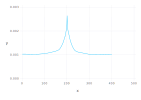

In [23]:
betas = fused_ridge_center(build_XtX(XtXcounts_30k[1:401]), Xty_30k[30001-200:30001+200], 10e9)
plot(x=1:length(betas), y=betas, Geom.line)

In [50]:
writedlm("ENCFF000NYK_vs_ENCFF000ODO_401_cr.txt", betas)

In [51]:
XtXcounts2_30k, Xty2_30k = learn_feature(
    "$root/$targetId.bam",
    "$root/$(controlIds[2]).bam",
    30000,
    useReverseReads=false
)
open(f->write(f, XtXcounts2_30k), "/tmp/XtXcounts2_30k.jbin", "w")
open(f->write(f, Xty2_30k), "/tmp/Xty2_30k.jbin", "w")

320000000
640000000
960000000
1280000000
1600000000
1920000000
2240000000
2560000000
2880000000
3200000000


480008

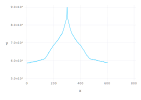

In [55]:
XtXcounts2_30k_binned = bin_values(XtXcounts2_30k, 100)
Xty2_30k_binned = bin_values(Xty2_30k, 100)
plot(x=1:length(Xty2_30k_binned), y=Xty2_30k_binned, Geom.line)

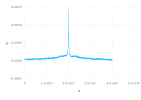

In [58]:
betas = inv(build_XtX(XtXcounts2_30k[1:4001]))*Xty2_30k[30001-2000:30001+2000]
plot(x=1:length(betas), y=betas, Geom.line)

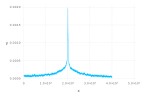

In [60]:
betas = inv(build_XtX(XtXcounts_30k[1:4001]))*Xty_30k[30001-2000:30001+2000]
plot(x=1:length(betas), y=betas, Geom.line)